# Digital phase locked loop using the Moku:Pro Phasemeter

by Jason Ball, Liquid Instruments

jason@liquidinstruments.com

Created: 2024/02/07

Last edited: 2024/12/13

This notebook will teach you how to implement a digital phase-locked loop using the Phasemeter on the Moku:Pro. An Oscilloscope is used to generate the signal (via the embedded Waveform Generator), which is then detected by the Phasemeter. The PM then produces its own phase-locked output, which is compared with the original signal on the Oscilloscope. 

In this configuration the demo can be performed on any Moku hardware. You could just as easily use a "proper" AWG or WG to generate more complicated signals, and this is left as an exercise for the reader. 

## Section 1: Import and Connect

In [3]:
### First we make our standard Python imports ###
### These are intended to help visualize the data in this demo ###
### They are not strictly necessary if you are not doing any manipulation or plotting of the data ###
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import collections
import time

In [5]:
### Now we make imports from the Moku package ###
### Import multi-instrument mode (MiM) plus all required instruments ###
from moku.instruments import MultiInstrument
from moku.instruments import Phasemeter
from moku.instruments import Oscilloscope

In [9]:
### Establish connection to the Moku ###
### This sets up the device in Multi-instrument Mode (MiM). ###
### Input your device's IP address as a string. ###
### Setting force connect to be true will boot anyone using the device ###
### Platform id is only required when using MiM. It will be 4 for Moku:Pro, and 2 for Moku:Lab and Moku:Go. Adjust accordingly ### 
### force_connect will overtake an existing connection
mim = MultiInstrument('192.168.###.###', force_connect=True, platform_id=2)

### Retrieve the hardware version, serial number, and firmware version from the instrument ### 
idn = mim.serial_number()
prop = mim.describe()
print('Connected to ' + prop['hardware'] + ', S/N ' + idn)
print('Firmware version ' + str(prop['firmware']))

Connected to Moku:Go, S/N 003468
Firmware version 601.0


## Section 2: Configure FPGA

In [12]:
### Now we define our instruments ###
### Use the set instrument command and the instruments we imported earlier ###
### The number corresponds to the slot on the Moku:Pro FPGA ###
phm = mim.set_instrument(1, Phasemeter)
osc = mim.set_instrument(2, Oscilloscope)

print('Instruments Set')

Instruments Set


In [14]:
### Define connection map ###
### The best way is to use a Python dictionary. Each connection has a source and destination. ###
### Slots are numbered 1-4, Inputs and Outputs are ordered A/B/C ###
### Send the output of the Phasemeter to input B of the Oscilloscope ###
### Send the output of the Scope to itself, as well as to the Phasemeter ###
### See the image below for reference ###

connections = [dict(source="Slot1OutA", destination="Slot2InB"),
               dict(source="Slot2OutA", destination="Slot1InA"),
               dict(source="Slot2OutA", destination="Slot2InA"),
               ]
### use set_connections with the dictionary we just generated ### 
mim.set_connections(connections=connections)

print('Connections Set')

Connections Set


## Section 3: Set up instruments

In [17]:
### Set up Frequency Source ###
### We use the Oscilloscope's embedded WG as the source that will be locked on to ###
### We generate a sine wave on Channel 1 (Output A), with peak-to-peak amplitude 1 V and frequency 10 MHz ###
osc.generate_waveform(channel=1, type='Sine', amplitude=1, frequency=10e6)

print('Frequency source configured')

Frequency source configured


In [19]:
### Set up Phasemeter ###
### We first set up a phase-locked loop. The first number selects the channel (1). ### 
### We tell the PM whether to automatically detect the frequency, and if not, which frequency clock to use. ### 
### Set the BW as well ###
phm.set_pm_loop(1,auto_acquire=False,frequency=10e6,bandwidth='100Hz')

### We turn on the phase-locked output, which will generate a sine wave with a constant phase offset from the input signal ###
phm.generate_output(1, signal='Sine', amplitude=1, phase_locked=True, frequency_multiplier=1)

### Synchronize ###
phm.sync_output_phase()

print('Phasemeter / PLL configured')

Phasemeter / PLL configured


In [21]:
### Set up Oscilloscope ###
### set the timebase for the oscilloscope to be a 500 ns window around the trigger event ### 
osc.set_timebase(-250e-9, 250e-9)

print('Oscilloscope configured')

Oscilloscope configured


## Section 4: Collect and plot results

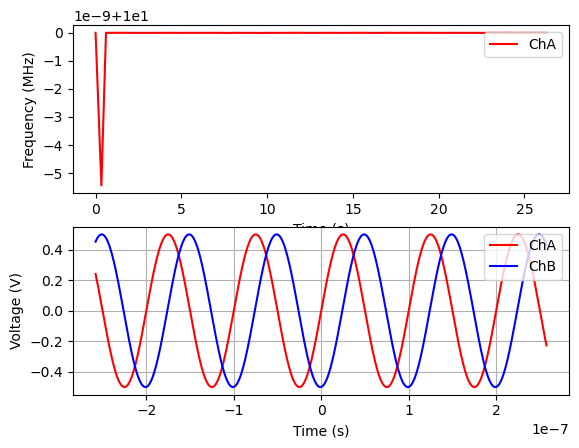

In [24]:
### Let's plot ### 
### Take traces from the PM and OSC sequentially ### 
### Make a couple of empty lists for later 
ph1 = []
elap = []
### Reset phasemeter before starting measurement ###
phm.reacquire()

### Set up a figure with two subplot ###
def live_plot(figsize=(6,4), title=''):
    clear_output(wait=True)
    fig, ax = plt.subplots(2)
    plt.title(title)
    plt.grid(True)
### We plot Frequency (measured by PM) vs time on one plot ###
    ax[0].plot(elap, ph1, 'r', label='ChA')
    ax[0].set_xlabel('Time (s)')
    ax[0].set_ylabel('Frequency (MHz)')
    ax[0].legend(loc='upper right')
### We plot both Oscilloscope ChA and ChB vs time on the second plot ###    
    ax[1].plot(data['time'], data['ch1'], 'r', label='ChA')
    ax[1].plot(data['time'], data['ch2'], 'b', label='ChB')
    ax[1].set_xlabel('Time (s)')
    ax[1].set_ylabel('Voltage (V)')
    ax[1].legend(loc='upper right') 
    plt.show();
 
### start a timer for the PM for real-time plotting
start = time.time()
# Then in a loop we reacquire the data and pass it to live_plot():
for i in range(100):
    done = time.time()
### get data from the Phasemeter, returned in dictionary form
    phm_data = phm.get_data()
### get data from the Oscilloscope, returned in dictionary form
    data = osc.get_data()
    ph1 += [phm_data['ch1']['frequency']/1e6] 
    # try 'frequency' or 'amplitude' as well 
    # add the value of elapsed time to the plot 
    elap += [done-start] 
    time.sleep(0.1)
    live_plot()